In [1]:
from common.utility import show_implementation
from module.utility import show_images

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
stitch0_image = Image.open("images/stitch0.png")
stitch0_image = np.array(stitch0_image.convert("L"))
stitch1_image = Image.open("images/stitch1.png")
stitch1_image = np.array(stitch1_image.convert("L"))

# Image Descriptor

In the [key points chapter](./key_points.ipynb), we determined a method to obtain good candidates for key points, *ie* points that good to track over image transformations.


Now that we've found these points of interest, we need a way to describe the region around the point, such that we can track the point before and after the transformation.
To do so, we use image descriptors

Descriptors are basically vectors which describes a region of the image mathematically.

To match a points, we compute the distance between every pair of descriptors around the keys points.

To achieve the above, it follows that descriptors have to be:
1. Invariant/Equivariant to geometric/photometric transformation
2. Discriminative: such that each point is (sufficiently) unique

## Intensity patch
We can take a square region around the pixel and simply unwind it into a 1-D vector.

Notice that this descriptor has the following properties:
* Invariant to geometric shifting
* Not invariant/equivariant to other geometric transformations
* Not invariant/equivariant to photometric transformations

Thus, this makes it a rather bad descriptor.
(But still has its uses, *ie* template matching)

## Patch Histogram
We can instead take the intensity histogram of the patch

Notice that this descriptor has the following properties:
* Invariant to scaling and rotation
* Not invariant/equivariant to photometric transformations
* Does not account for spatial layout of the image, as shown in the [point processing chapter](./point_processing.ipynb#histogram-spatial)


## Spatial Histogram
In addition, we can split the patch into smaller cells.
This help retain some spatial information of the patch, whilst having the invariance to some deformations.


## Rotation invariance
To achieve rotation invariance for our descriptor, we can first find the direction of the dominant gradient in the patch, then rotate the patch based on this angle.
This orients the patch relative to its dominant gradient vector.

### Dominant gradient vector

How do we obtain the dominant gradient vector?

One approach is to obtain the average of the gradient orientation.
However, this might overly smooth out the signal.

Another potential approach is to use the mode instead.

# Concrete Descriptors

Here are a few examples of descriptors that were discovered.

## Multi-scale Oriented Patches (MOPS)
1. Obtain a 40 x 40 patch around the key point
2. Subsample every 5-th pixel
3. Rotate to horizontal orientation
4. Normalize the intensity value by subtracting the mean and dividing by standard deviation of the patch
5. Wavelet transform the 8 x 8 patch to get a 64-D descriptor

## GIST Descriptor
1. Divide the image into 4 x 4 cells
2. Apply Gabor filters
3. Compute the average filter response for each cell
4. The descriptor will be size 4 x 4 x (size of filter bank)

## Scale Invariant Feature Transform (SIFT)
The SIFT paper describes both a key point detector (blob detector) and a descriptor.
We will be focusing on the descriptor portion.

1. Obtain a 16 x 16 patch
2. Split the patch into 4 x 4 grid of cells
3. Compute the gradient orientation + magnitude for each pixel
4. Reweight magnitude based on Gaussian centered on key point
5. Discard low magnitude pixels
6. Using the remaining pixels, obtain their edge orientation and create a histogram with 8 bins for each cell
7. Shift the histogram to binned by dominant orientation
8. Collapse each histogram into a 8-D vector (corresponds to the 8 bins)
9. Descriptor is size 16 x 8
10. Normalize the vector to unit length
11. Clamp the values based on some threshold
12. Renormalize to obtain the final descriptor

## Example

In [3]:
p1 = (90, 530)
p2 = (100, 430)
p3 = (200, 300)

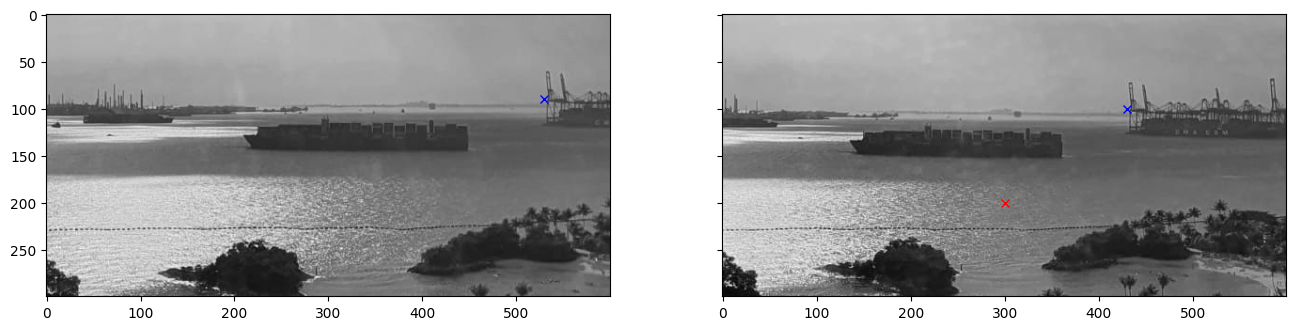

In [4]:
fig = plt.figure(figsize=(16, 10))
axs = fig.subplots(1, 2, sharex=True, sharey=True)

axs[0].imshow(stitch0_image, cmap="gray")
axs[1].imshow(stitch1_image, cmap="gray")
axs[0].plot(p1[1], p1[0], "bx")
axs[1].plot(p2[1], p2[0], "bx")
axs[1].plot(p3[1], p3[0], "rx")
plt.show()

Suppose that we have the above 2 points in different images.
Notice that they are in different images, but contains a similar view, thus we expect our descriptor to describe them as similar.

For comparison, we will also compute the descriptor around another point (red 'x').

In [5]:
from module.descriptor import bin_grid, sift, get_patch

show_implementation(get_patch)
show_implementation(bin_grid)
show_implementation(sift)

def get_patch(image, p):
    y, x = p
    # We obtain a 18x18 patch to obtain a 16x16 magnitude patch as the convolution will reduce our patch size
    if x < 9 or y < 9 or x + 9 > image.shape[1] or y + 9 > image.shape[0]:
        raise ValueError("unable to obtain 16x16 patch")

    patch = image[y - 9: y + 9, x - 9:x + 9]
    return patch
def bin_grid(mags, thetas, threshold):
    hist = np.zeros((8,))

    thetas += np.pi
    for mag, theta, in zip(mags.ravel(), thetas.ravel()):
        if mag < threshold:
            continue
        i = int(theta / (2 * np.pi / 8))
        if i == 8:
            i = 7

        hist[i] += 1

    amax = hist.argmax()

    hist = np.concatenate((hist[amax:], hist[:amax]))

    return hist
def sift(image, p, threshold=1e-12):
    patch = get_patch(image, p)
    mags, thetas = compute_gradient(patch)

    gaussian = gaussian_filter(17, sigma=10)[:16, :16]

    mags = (mags * gaussian).reshape(4, 4, -1,
                                     4).swapaxes(1

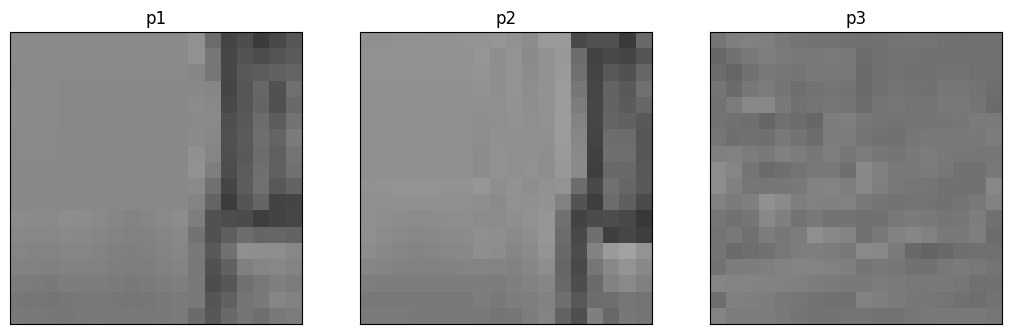

In [6]:
show_images(
    (get_patch(stitch0_image, p1), "p1"),
    (get_patch(stitch1_image, p2), "p2"),
    (get_patch(stitch1_image, p3), "p3"),
)

These are the 3 patches that we extracted. 
We expect $p1$ to be similar to $p2$, but different from $p3$.

In [7]:
d1 = sift(stitch0_image, p1)
d2 = sift(stitch1_image, p2)
d3 = sift(stitch1_image, p3)

In [8]:
def euclidean_dist(h1, h2):
    return np.sqrt(np.abs((h1 - h2) ** 2).sum())

In [9]:
euclidean_dist(d1, d2)

1.6044822494981474

In [10]:
euclidean_dist(d1, d3)

1.6182359349277184

Indeed, we can see that the descriptor of $p1$ is more similar to $p2$ than $p3$. 
We can also observe it from the plot below.

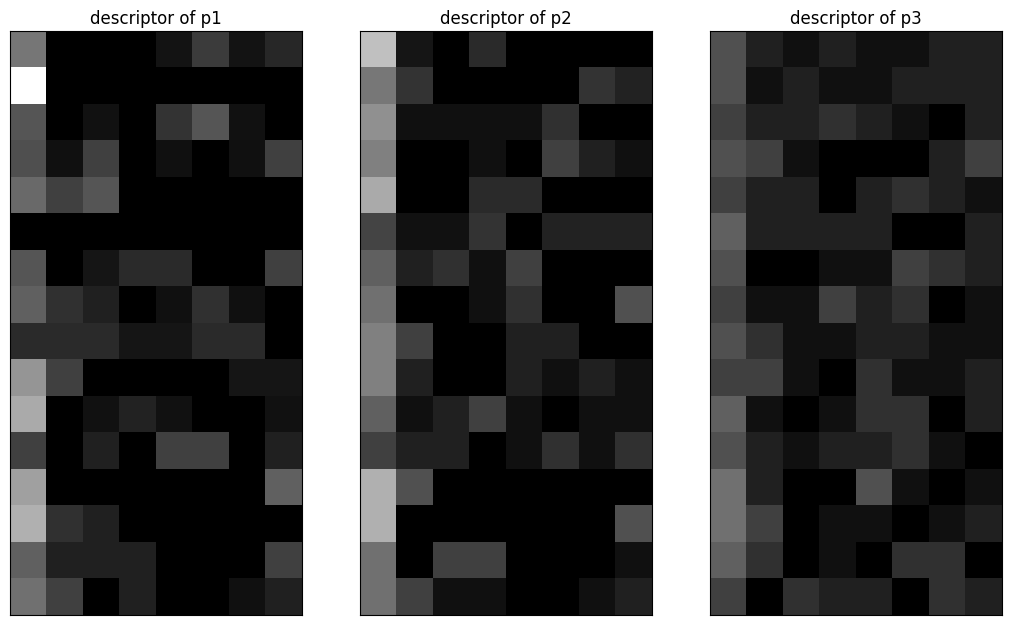

In [11]:
show_images(
    (d1, "descriptor of p1"), (d2, "descriptor of p2"), (d3, "descriptor of p3")
)

### Properties of SIFT
* Invariant to scale/rotation
* Accounts for changes in viewpoint
* Accounts for changes in illumination
* Efficient

# Feature matching

Now that we've found key points, and a way to describe the region around the key point, the next step is a way to determine the similarity between two key points.

## Feature distance

Given two features $f_1, f_2$, we need a way to describe the distance between them.

A naive approach is to use $||f_1 - f_2||$, where $|| \cdot ||$ is the typical distance function, such as Euclidean distance.

However, consider the case where a certain key point $f_1$ is similar to 2 different key points ($f_2$ and $f_3$) in the new image.
If we used our naive approach, we would have match $f_1$ to $f_2$, even though the closest match was ambiguous. 
It is possible that the correct match was with $f_3$ (and $f_3$ was not computed to be the closest due to noise in the image/inaccuracy in the descriptor).

Hence, a better distance metric is $\frac{||f_1-f_2||}{||f_1-f_3||}$ as proposed by the SIFT paper.